In [1]:
import networkx as nx
import seir
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats as st
import itertools as it
from tqdm import tqdm_notebook as tqdm

The first modification to the simulation we're implementing is dynamic graphs; the graph over which the simulation operates changes over time.

We're going to simulate "movement" throughout the day as "periods", like in high school. I'm assuming location information from the app can be chunked into periods. We'll assume that the people at a location in a particular period are isolated, that is, for that period they can only transmit to each other. People travel to different locations between periods however. Given n periods, we're going to need a list of n graphs (if we choose to split things by period.) A sample schedule is below. 

In [2]:
names=[]
nperiods=10
npeople=20  #maxes out at 148
with open('sample_names.rtf') as f:
    names.append(f.readlines())
fmt_names =list(set([x.strip().replace(' \\\'a0\\','') for x in names[0][8:]]))[:npeople]
locations=['Rustem Lab', 'Pierce Lab', 'Arnold Lab','Broad','Noyes','Schlinger','Spaulding']


schedule = np.random.choice(locations,size=nperiods*len(fmt_names)) 
schedule = np.reshape(schedule,newshape=[nperiods,len(fmt_names)])
schedule_df = pd.DataFrame(schedule,columns=fmt_names)
schedule_df.head()

,Thelma,Beverly,Raguel,Evangeline,Annabel,Temple,Kristeen,Petra,Rima,Debbi,Erik,Bruce,Clelia,Leonel,Roberto,Cinda,Sherly,Wilhelmina,Sheba,Domenica
0,Arnold Lab,Spaulding,Rustem Lab,Arnold Lab,Schlinger,Arnold Lab,Broad,Spaulding,Schlinger,Pierce Lab,Schlinger,Noyes,Rustem Lab,Noyes,Rustem Lab,Noyes,Broad,Arnold Lab,Schlinger,Noyes
1,Schlinger,Spaulding,Spaulding,Broad,Broad,Broad,Broad,Rustem Lab,Schlinger,Pierce Lab,Schlinger,Broad,Arnold Lab,Pierce Lab,Spaulding,Rustem Lab,Pierce Lab,Schlinger,Rustem Lab,Schlinger
2,Arnold Lab,Schlinger,Arnold Lab,Spaulding,Noyes,Rustem Lab,Rustem Lab,Spaulding,Pierce Lab,Rustem Lab,Arnold Lab,Broad,Arnold Lab,Rustem Lab,Spaulding,Spaulding,Noyes,Pierce Lab,Broad,Rustem Lab
3,Spaulding,Arnold Lab,Schlinger,Noyes,Noyes,Rustem Lab,Spaulding,Spaulding,Rustem Lab,Schlinger,Arnold Lab,Schlinger,Broad,Noyes,Broad,Arnold Lab,Rustem Lab,Schlinger,Rustem Lab,Spaulding
4,Schlinger,Pierce Lab,Broad,Rustem Lab,Pierce Lab,Noyes,Pierce Lab,Rustem Lab,Arnold Lab,Broad,Rustem Lab,Arnold Lab,Schlinger,Broad,Broad,Broad,Noyes,Broad,Arnold Lab,Noyes


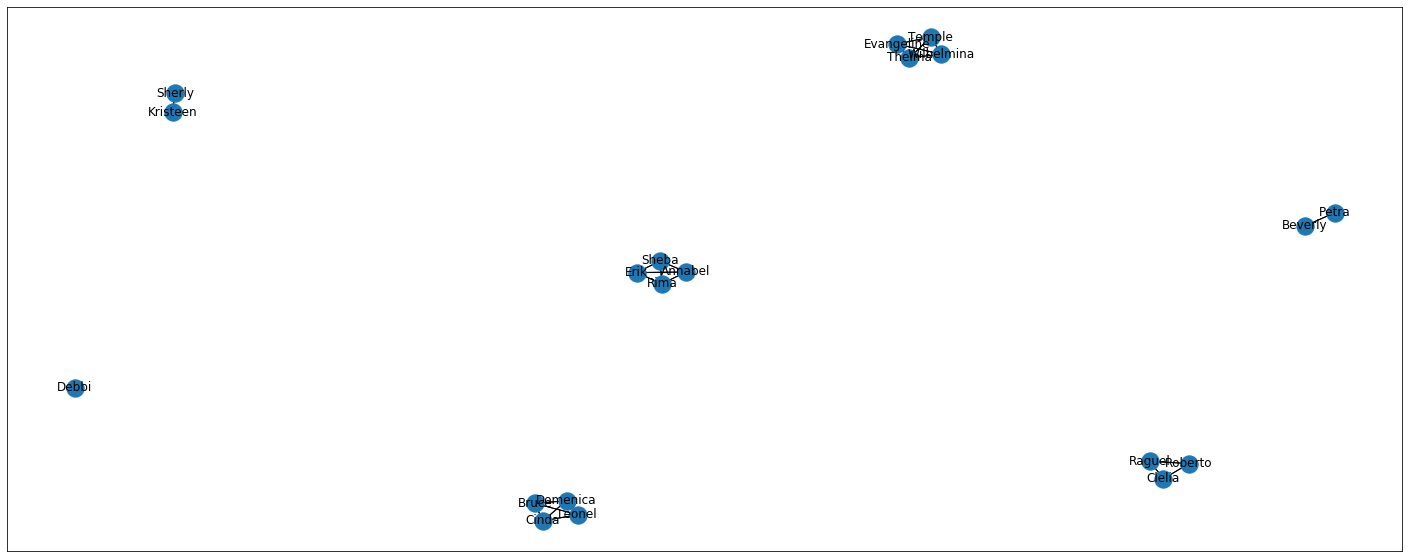

In [3]:
#let's generate a graph based on the schedule
G_list = []

for period_idx in range(len(schedule_df.index)):
    G = nx.MultiGraph()
    G.add_nodes_from(fmt_names)
    edgelist=[]
    current_series = schedule_df.iloc[period_idx]
    #full-connect all individuals at the same location
    for location_idx in range(len(locations)):
        current_location = locations[location_idx]
        current_names = list(current_series[current_series==current_location].index)
        edgelist.append(list(it.product(current_names,current_names)))
        
    #we need to concatenate all the edges into a single list
    edgelist=list(set(sum(edgelist,[])))
    G.add_edges_from(edgelist)
    G_list.append(G)
G_list
nx.draw_networkx(G_list[0],nodelist=fmt_names)

The above is a representation of the graph for a single period. We can also make a graph for the entire day, shown below.

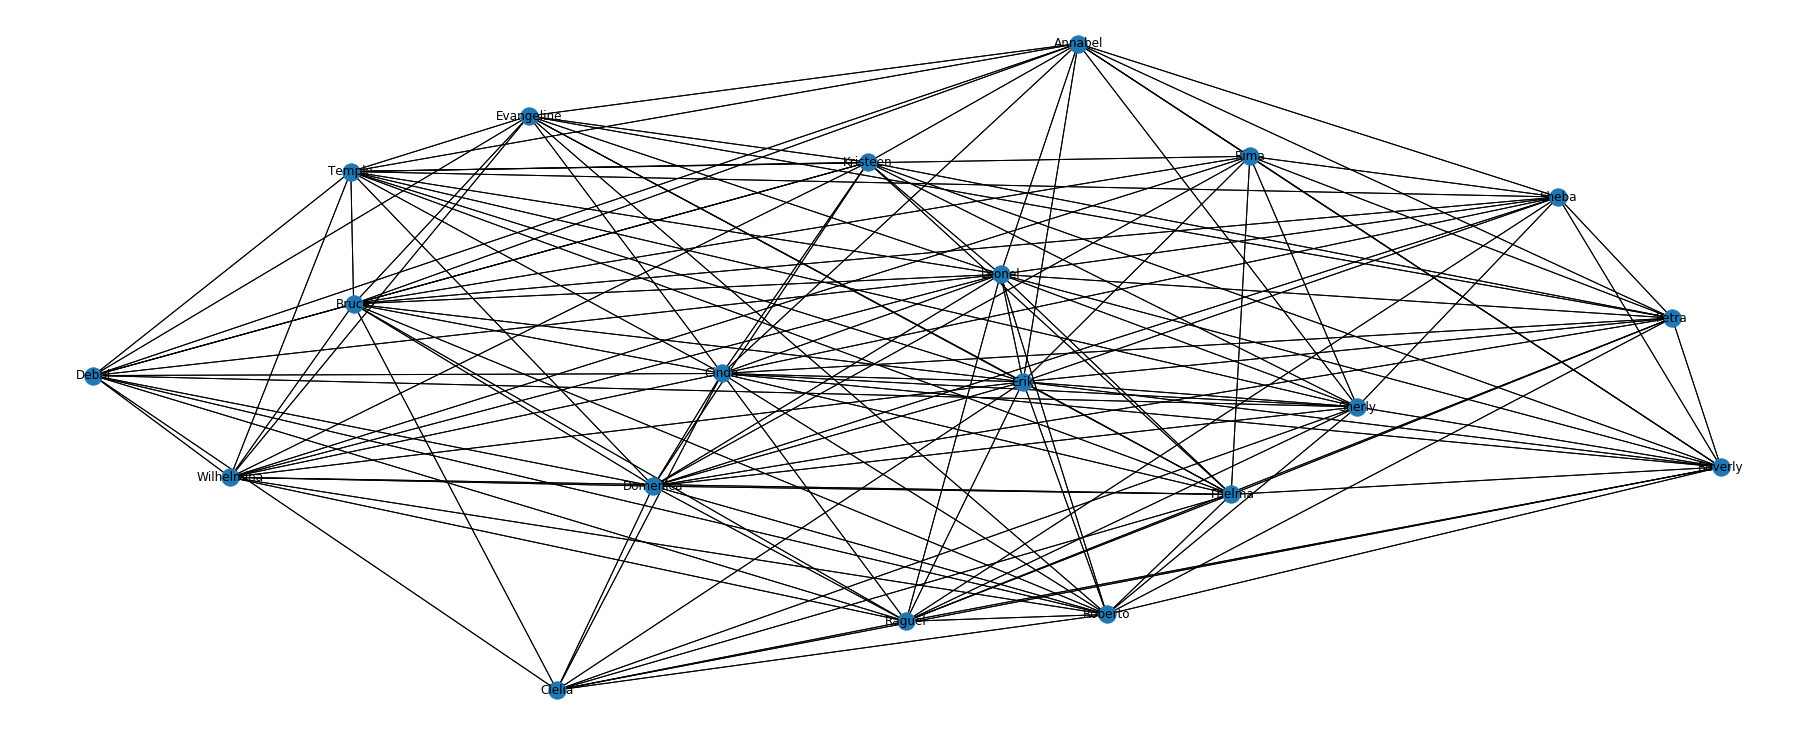

In [4]:
#let's a large graph over all periods to vizualize the entire day at once
G = nx.MultiGraph()
G.add_nodes_from(fmt_names)
edgelist=[]


for period_idx in range(len(schedule_df.index)):

    current_series = schedule_df.iloc[period_idx]
    #full-connect all individuals at the same location
    for location_idx in range(len(locations)):
        current_location = locations[location_idx]
        current_names = list(current_series[current_series==current_location].index)
        edgelist.append(list(set(it.product(current_names,current_names))))
        
    #we need to concatenate all the edges into a single list
edgelist=list(set(sum(edgelist,[])))
G.add_edges_from(edgelist)

nx.draw_kamada_kawai(G,with_labels=True)

Plugging the graph into the SEIR model and doing a trial run

In [5]:
res1 = seir.simulation(G=G,prob_exposed_detected=0.1,verbose=False)
res1.summary()

duration                    18.041667
fraction_infected            1.000000
doubling_days                     inf
fraction_quarantine_time     1.483333
peak_infected_time           0.000000
peak_fraction_infected       0.500000
fraction_tests               1.165347
peak_test_rate               0.097083
dtype: float64


SEIR runs are stochastic, we can get a better picture by constructing confidence intervals around SEIR runs...this is where we can take advantage of parallel computing.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Text(0, 0.5, 'Fraction')

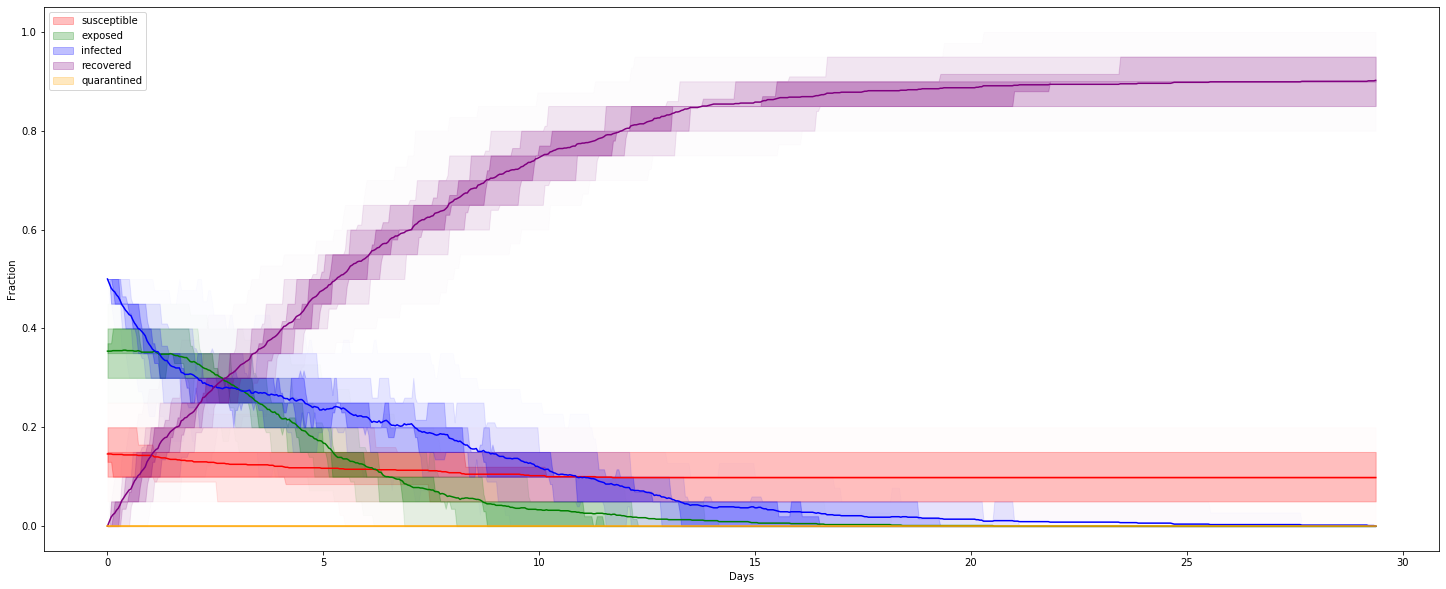

In [6]:
ntrials = 50
G=G

colorlist=['red','green','blue','purple','orange']
species = ['susceptible','exposed','infected','recovered','quarantined']
alphalist = np.linspace(0.01,0.25,4)
triallist=[[],[],[],[],[],[]]
for trial_idx in tqdm(range(ntrials)):
    
    result = seir.simulation(G=G_list,prob_exposed_detected=0.,prob_infected_detected=0.,prob_neighbor_detected=0.,verbose=False)
    
    triallist[0].append(result.df['day'].values)
    triallist[1].append(result.df['susceptible'].values / result.N)
    triallist[2].append(result.df['exposed'].values / result.N)
    triallist[3].append(result.df['infected'].values / result.N)
    triallist[4].append(result.df['recovered'].values / result.N)
    triallist[5].append(result.df['quarantined'].values / result.N)

#we need to create a master timelist from the xaxes of all trials
xax = np.unique(np.concatenate(triallist[0]))
outputarray = np.empty(shape=[xax.size,ntrials,5])  #5 in the last dimension represents seirq

for time_idx in range(xax.size):
    current_time = xax[time_idx]
    for trial_idx in range(ntrials):
        for species_idx in range(len(species)):
            #going by "price is right rules", closest time to x without going over
            insert_idx = min([np.searchsorted(triallist[0][trial_idx],current_time),triallist[0][trial_idx].size-1])
            outputarray[time_idx,trial_idx,species_idx] = triallist[species_idx+1][trial_idx][insert_idx]  #the +1 is because I added the xaxis to the front of the list

            
fig,ax = plt.subplots()
for species_idx in range(len(species)):
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],5,axis=1),np.percentile(outputarray[:,:,species_idx],95,axis=1),color=colorlist[species_idx],alpha=alphalist[0])
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],20,axis=1),np.percentile(outputarray[:,:,species_idx],80,axis=1),color=colorlist[species_idx],alpha=alphalist[1])
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],30,axis=1),np.percentile(outputarray[:,:,species_idx],70,axis=1),color=colorlist[species_idx],alpha=alphalist[2])
    ax.fill_between(xax,np.percentile(outputarray[:,:,species_idx],40,axis=1),np.percentile(outputarray[:,:,species_idx],60,axis=1),color=colorlist[species_idx],alpha=alphalist[3],label=species[species_idx])
    ax.plot(xax,np.mean(np.squeeze(outputarray[:,:,species_idx]),axis=1),color=colorlist[species_idx])
    ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Fraction')

Right now, I think we should implement sample pooling into the testing function as right now every person gets a test to themselves. 